In [1]:
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import json

import os

pd.options.mode.chained_assignment = None 
from importlib import reload

import utils_processing.cluster_processing as cluster_processing
reload(cluster_processing)

from dotenv import load_dotenv
load_dotenv()

import networkx as nx
from collections import Counter

ModuleNotFoundError: No module named 'utils_processing'

In [2]:
b_dir = os.getenv('DATA_FOLDER')
base_folder = f"{b_dir}/interactions_data_new"

cutoff = 6

output_dir = f"{base_folder}/interactions_analyses"
Path(output_dir).mkdir(parents=True, exist_ok=True)

WF2_base_folder = os.getenv('WF2_BASE_FOLDER')
WF1a_base_folder = os.getenv('WF1A_BASE_FOLDER')

WF2_umap_dssp = pd.read_csv(f"{WF2_base_folder}/structure_dssp_frames_different_ref.csv")
WF2_umap_time = pd.read_csv(f"{WF2_base_folder}/clusters_time_frames_different_ref2.csv")
WF2_umap_time
WF2_umap_time = WF2_umap_time.rename(columns={"Unnamed: 0": "peptide"}).set_index("peptide")
WF2_umap_time.columns = [int(float(x)/50) for x in WF2_umap_time.columns.tolist()]


WF1a_umap_time = pd.read_csv(f"{WF1a_base_folder}/clusters_time_frames_different_ref2.csv")
WF1a_umap_dssp = pd.read_csv(f"{WF1a_base_folder}/structure_dssp_frames_different_ref.csv")
WF1a_umap_time = WF1a_umap_time.rename(columns={"Unnamed: 0": "peptide"}).set_index("peptide")
WF1a_umap_time.columns = [int(float(x)/50) for x in WF1a_umap_time.columns.tolist()]

WF2_umap_time_array = WF2_umap_time.values
WF1a_umap_time_array = WF1a_umap_time.values
WF1a_umap_time


,0,2,4,6,8,10,12,14,16,18,...,482,484,486,488,490,492,494,496,498,500
peptide,,,,,,,,,,,,,,,,,,,,,
1,6,6,6,6,6,6,12,8,12,12,...,7,7,7,7,7,7,7,7,7,7
2,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
3,12,12,12,11,11,11,11,12,11,11,...,8,8,8,8,8,8,8,8,8,8
4,12,12,12,12,12,12,12,12,12,12,...,11,11,11,11,11,11,11,11,11,11
5,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
6,2,2,6,12,12,12,12,12,12,12,...,2,2,2,2,2,2,2,2,2,2
7,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
8,12,12,12,12,12,12,12,12,12,12,...,5,5,5,5,5,5,5,5,5,5
9,10,10,10,10,10,10,10,10,10,10,...,7,7,7,7,7,7,7,7,7,7


In [3]:
def get_pep_combined(peptide_num, peptide_type):
    if "only" in peptide_type:
        return peptide_type.split("_")[0]
    else:  
        if peptide_num in range(0,5):
            return "WF1a"
        else:
            return "WF2"
        
def get_pep_from_res(res, pep_type):
    if "WF1a_only" in pep_type:
        pep_dict = \
            {1: (1, 20),
            2: (21, 40),
            3: (41, 60),
            4: (61, 80),
            5: (81, 100),
            6: (101, 120),
            7: (121, 140),
            8: (141, 160)}
    elif "WF2_only" in pep_type:
        pep_dict = {
            1: (1, 25),
            2: (26, 50),
            3: (51, 75),
            4: (76, 100),
            5: (110, 125),
            6: (126, 150),
            7: (151, 175),
            8: (176, 200)}
    else:
        pep_dict = {1: (1, 20),
                2: (21, 40),
                3: (41, 60),
                4: (61, 80),
                5: (81, 105),
                6: (106, 130),
                7: (131, 155),
                8: (156, 180)}

    val = None
    for k, v in pep_dict.items():
        if int(res) in range(v[0], v[1]+1):
            val = k

    return val


def find_longest_consecutive_ones(data):

    current_count = 1
    longest_count = 1
    longest_start = 0
    current_start = 0

    for i in range(1, len(data)):
        if data[i] == 1:
            current_count += 1
            if current_count > longest_count:
                longest_count = current_count
                longest_start = current_start
    else:
        current_count = 0
        current_start = i

    # Check the last element as it might be part of the longest sequence
    if data[-1] == 1 and current_count > longest_count:
        longest_count = current_count
        longest_start = current_start
    return data[longest_start:longest_start + longest_count]


def import_distance_data():
    sim_type = "WF1a_WF2"

    base_folder_distances = f"{b_dir}/distances"
    df_contacts = pd.read_csv(f"{base_folder_distances}/distance_over_time_WF1a_WF2_pg_100timestep_new.csv")
    df_contacts = df_contacts.drop(columns=["Unnamed: 0"])


    df_contacts = df_contacts.drop(columns=[str(i) for i in range(250)])
    df_contacts = df_contacts.drop(columns=["500"])
    df_contacts = df_contacts.rename(columns={str(i):int(i)-250 for i in range(250, 501)})

    # Get peptide from residue
    df_contacts["pep1"] = df_contacts["Peptide1"].apply(lambda x: get_pep_from_res(x, sim_type))
    df_contacts["pep2"] = df_contacts["Peptide2"].apply(lambda x: get_pep_from_res(x, sim_type))
    df_contacts = df_contacts.rename(columns={str(i):int(i) for i in range(250)})
    df_contacts[[i for i in range(250)]] = df_contacts[[i for i in range(250)]].astype(int)

    # Transform distances to 0 or 1
    df_contacts[[i for i in range(250)]] = df_contacts[[i for i in range(250)]].mask(df_contacts[[i for i in range(250)]]>=5, 0)
    df_contacts[[i for i in range(250)]] = df_contacts[[i for i in range(250)]].mask(df_contacts[[i for i in range(250)]]>0, 1)

    # Map to peptide type
    df_contacts["peptype_1"] = df_contacts["pep1"].apply(lambda x: get_pep_combined(x, sim_type))
    df_contacts["peptype_2"] = df_contacts["pep2"].apply(lambda x: get_pep_combined(x, sim_type))

    return df_contacts



In [4]:
def get_pep_combined(peptide_num, peptide_type):
    # peptide_num = int(row[pep_column][3:])
    if "only" in peptide_type:
        return peptide_type.split("_")[0]
    else:  
        if peptide_num in range(0,5):
            return "WF1a"
        else:
            return "WF2"

def map_pep_to_umap(pep_name, pep_num, sim_type, sim_number):

    if "only" in sim_type:
        pep = pep_num + 8
        if sim_number == 2:
            pep = pep_num + 16
    else:
        if pep_name=="WF1a":
            if sim_number == 1:
                pep = pep_num
            else:
                pep = pep_num + 4
        else:
            if pep_name =="WF2":
                if sim_number == 1:
                    pep = pep_num -4
                else:
                    pep = pep_num 
    return pep

def map_pep_to_cluster(t, cluster_pep, pep_name):
    if pep_name == "WF2":
        cluster = WF2_umap_time_array[cluster_pep-1, t]
    else:   
        cluster = WF1a_umap_time_array[cluster_pep-1, t]
    return cluster

def import_raw_aggregate_data(peptide, sim_num, cutoff):
    """ 
    Inputs:
        peptide: str
            cound be "WF1a_WF2" or WF1a_only, "WF2_only
        sim_number: 1 or 2
        cutoff: int
            Could be 3, 5, 10
    """
    base_aggregate_data = f"{b_dir}/interactions_data"
    if sim_num == 2:
        aggregate_data = \
            pd.read_csv(f"{base_aggregate_data}/{peptide}_replica_interactions_true_false_100timestep_cutoff{cutoff}.csv")
        print("reading file ", f"{peptide}_replica_interactions_true_false_100timestep_cutoff{cutoff}.csv" )
    else:
        aggregate_data = \
            pd.read_csv(f"{base_aggregate_data}/{peptide}_interactions_true_false_100timestep_cutoff{cutoff}.csv")
        print("reading file ", f"{peptide}_interactions_true_false_100timestep_cutoff{cutoff}.csv" )
    aggregate_data = aggregate_data.set_index("Peptide_Pair")

    aggregate_data.columns = [int(float(c)) for c in aggregate_data.columns.tolist()]
    ## deal with wf1a_wf2 sim being 1 microsec
    aggregate_data.columns = [i-500 for i in aggregate_data.columns.tolist()]
    # transform columns so all times are between 500 and 1000
    aggregate_data.columns=[int(i/2) for i in aggregate_data.columns.tolist()]
    return aggregate_data


def get_clusters_at_time(G, list_pairs):
    for i in list_pairs:
        G.add_edge(i[0], i[1])
    list_clusters = []
    sub_graphs = nx.connected_components(G)
    while True:
        try:
            x = next(sub_graphs)
            list_clusters.append(x)
        except StopIteration:
            break
    return G, list_clusters

In [5]:
sim_type = "WF1a_WF2"
sim_number = 2


def get_clusters_per_system(sim_type, sim_num, cutoff, analysis_type):
    df = import_raw_aggregate_data(sim_type, 
    sim_num, cutoff)
    print(df)
    dict_times = {c: [] for c in range(251)}
    for index, row in df.iterrows():
        peptides = [int(index.split("_")[0][-1]), int(index.split("_")[1][-1])]
        pep1 = peptides[0]
        pep2 = peptides[1]

        
        row = row.tolist()
        for t in range(len(row)):
            if row[t] > 0:
                if analysis_type == "peptide":
                    dict_times[t].append((pep1, pep2))
                else:
                    print("no type specified")

    dict_times_clusters = {}
    dict_times_clusters = {c:[] for c in dict_times.keys()}
    for k, v in dict_times.items():
        G = nx.Graph()
        G.add_nodes_from(range(1, 9))   
        dict_times_clusters[k] = get_clusters_at_time(G, v)[1]
    return dict_times_clusters

## Mer distribution

In [6]:

def get_mono_hetero_old(sim_type, sim_number, cutoff):
    d1 = get_clusters_per_system(sim_type, sim_number, cutoff, "peptide")
    # Transform into_pep_type
    all_cluster_by_type = []
    for t, v in d1.items():
        for cluster in v:
            transform_cluster = []
            for e in cluster:
                transform_cluster.append(get_pep_combined(e, sim_type))
            all_cluster_by_type.append(transform_cluster)

    mer_WF1a = {"mono": {c:0 for c in range(1,9)},
                "hetero": {c:0 for c in range(1,9)}}
    mer_WF2 = {"mono": {c:0 for c in range(1,9)},
                "hetero": {c:0 for c in range(1,9)}}


    for cluster in all_cluster_by_type:
        if len(cluster) == 1:
            if "WF1a" in cluster:
                mer_WF1a["mono"][1] += 1
            if "WF2" in cluster:
                mer_WF2["mono"][1] += 1
        else:
            if len(np.unique(cluster)) == 1: # check if mono
                mer_order = len(cluster)
                if "WF1a" in cluster:
                    mer_WF1a["mono"][mer_order] += mer_order
                if "WF2" in cluster:
                    mer_WF2["mono"][mer_order] += mer_order
            else:
                mer_order = len(cluster)
                mer_WF1a["hetero"][mer_order] += cluster.count("WF1a")
                mer_WF2["hetero"][mer_order] += cluster.count("WF2")
    return pd.DataFrame(mer_WF1a).T, pd.DataFrame(mer_WF2).T

def get_mono_hetero(sim_type, sim_number, cutoff):
    d1 = get_clusters_per_system(sim_type, sim_number, cutoff, "peptide")
    # Transform into_pep_type
    all_cluster_by_type = []
    for t, v in d1.items():
        for cluster in v:
            transform_cluster = []
            for e in cluster:
                transform_cluster.append(get_pep_combined(e, sim_type))
            all_cluster_by_type.append(transform_cluster)

    mer_WF1a = {"homomer": {c:0 for c in range(1,9)},
                "heteromer": {c:0 for c in range(1,9)}}
    mer_WF2 = {"homomer": {c:0 for c in range(1,9)},
                "heteromer": {c:0 for c in range(1,9)}}


    for cluster in all_cluster_by_type:
        if len(cluster) == 1:
            if "WF1a" in cluster:
                mer_WF1a["homomer"][1] += 1
            if "WF2" in cluster:
                mer_WF2["homomer"][1] += 1
        else:
            if len(np.unique(cluster)) == 1: # check if mono
                mer_order = len(cluster)
                if "WF1a" in cluster:
                    mer_WF1a["homomer"][mer_order] += mer_order
                if "WF2" in cluster:
                    mer_WF2["homomer"][mer_order] += mer_order
            else:
                mer_order = len(cluster)
                if "WF1a" in cluster:
                    mer_WF1a["heteromer"][mer_order] += cluster.count("WF1a")
                if "WF2" in cluster:
                    mer_WF2["heteromer"][mer_order] += cluster.count("WF2")
    return pd.DataFrame(mer_WF1a).T, pd.DataFrame(mer_WF2).T

In [7]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

reading file  WF1a_WF2_interactions_true_false_100timestep_cutoff6.csv
              0    1    2    3    4    5    6    7    8    9    ...  241  242  \
Peptide_Pair                                                    ...             
pep1_pep2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep7     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
pep1_pep8     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep2_pep3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep2_pep4     1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  ...  1.0  1.0   
pep2_pep5     0.0  0.0  0.0  0.0  0.0 

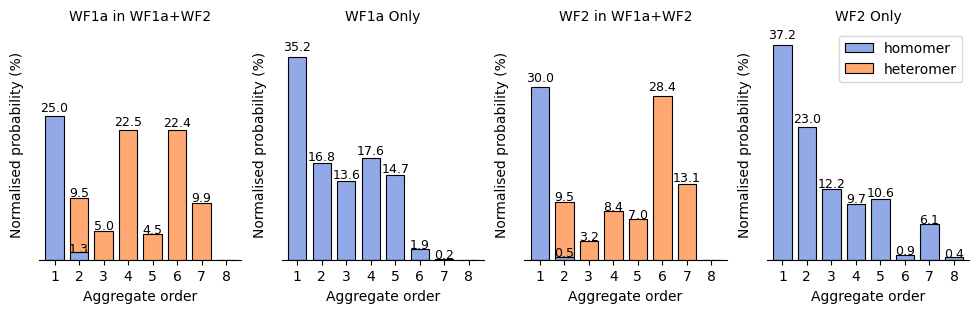

In [8]:
wf1a_comb1, wf2_comb1 = get_mono_hetero("WF1a_WF2", 1, cutoff)
wf1a_comb2, wf2_comb2 = get_mono_hetero("WF1a_WF2", 2, cutoff)

wf1a_comb2, wf2_comb2 = get_mono_hetero("WF1a_WF2", 2, cutoff)

wf1a_only1, _ = get_mono_hetero("WF1a_only", 1, cutoff)
wf1a_only2, _ = get_mono_hetero("WF1a_only", 2, cutoff)

_, wf2_only1 = get_mono_hetero("WF2_only", 1, cutoff)
_, wf2_only2 = get_mono_hetero("WF2_only", 2, cutoff)

wf1a_hetero = (wf1a_comb1 + wf1a_comb2) / (2*4) 
wf1a_hetero = wf1a_hetero/np.sum(wf1a_hetero.values)*100

wf2_hetero = (wf2_comb1 + wf2_comb2) / (2*4) 
wf2_hetero = wf2_hetero/np.sum(wf2_hetero.values)*100

wf1a_hetero_only = (wf1a_only1 + wf1a_only2) / (2*8) 
wf1a_hetero_only = wf1a_hetero_only/np.sum(wf1a_hetero_only.values)*100

wf2_hetero_only = (wf2_only1 + wf2_only2) / (2*8) 
wf2_hetero_only = wf2_hetero_only/np.sum(wf2_hetero_only.values)*100

plt.style.use('default')
plt.rc('axes', titlesize=10)
plt.rcParams['font.size'] = 10

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex=True)
colors = ["#FFB000","#FE6100" ]
# colors = ["#E1BE6A","#40B0A6" ]
colors = ["#1A85FF", "#D41159" ]
# colors = ["#E8BC35", "#D35FB7"]
colors = ["#785EF0", "#DC267F"]
colors = ["#FFA872", "#91A9E6"]
colors = ["#91A9E6", "#FFA872"]
color_palette = colors

ax_0 = wf1a_hetero.T.plot(
    kind='bar', 
    stacked=True, 
    ax=axs[0],
    edgecolor = "black",
    color=color_palette,
    legend=False,
    width=0.75,
    linewidth=0.8)
ax_0.set_title("WF1a in WF1a+WF2") 

ax_1 = wf1a_hetero_only.T.plot(
    kind='bar', 
    stacked=True, 
    ax=axs[1],
    edgecolor = "black",
    color=color_palette,
    legend=False,
    width=0.75,
    linewidth=0.8)
ax_1.set_title("WF1a Only") 

ax_2 = wf2_hetero.T.plot(
    kind='bar', 
    stacked=True, 
    ax=axs[2],
    edgecolor = "black",
    color=color_palette,
    legend=False,
    width=0.75,
    linewidth=0.8)
ax_2.set_title("WF2 in WF1a+WF2") 

ax_3 = wf2_hetero_only.T.plot(
    kind='bar', 
    stacked=True, 
    ax=axs[3],
    edgecolor = "black",
    color=color_palette,
    legend=False,
    width=0.75,
    linewidth=0.8)
ax_3.set_title("WF2 Only", y=1) 

for ax in axs:
    ax.spines.top.set(visible=False)
    ax.spines.right.set(visible=False)
    ax.set_xlabel("Aggregate order")
    ax.set_ylabel("Normalised probability (%)")
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_ylim([0, 40])
    ax.set_yticklabels([])
    ax.tick_params(left=False)
    ax.spines["left"].set_visible(False)


for ax in axs:
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        if height>0:
            ax.annotate("{:.1f}".format(height), (x + width/2, y + height*1.03), ha='center',fontsize=9)
plt.legend()

In [12]:
def get_aggregates_cluster(sim_type, sim_number, cutoff):
    d1 = get_clusters_per_system(sim_type, sim_number, cutoff,"peptide")
    # Transform into_pep_type
    all_cluster_by_type = []
    for t, v in d1.items():
        transform_cluster = []
        for cluster in v:
            for e in cluster:
                pep_type = get_pep_combined(e, sim_type)
                pep_umap = map_pep_to_umap(pep_type, e, sim_type, sim_number)
                pep_cluster = map_pep_to_cluster(t, pep_umap, pep_type)
                transform_cluster.append(f"{pep_cluster}_{pep_type}")
        all_cluster_by_type.append(transform_cluster)
    return all_cluster_by_type

### Distribution per cluster per mer

In [14]:
def get_mer_distribution_per_cluster(sim_type, sim_number, cutoff):
    d1 = get_clusters_per_system(sim_type, sim_number, cutoff,"peptide")
    # Transform into_pep_type
    all_cluster_by_type = []
    for t, v in d1.items():
        for cluster in v:
            transform_cluster = []
            for e in cluster:
                pep_type = get_pep_combined(e, sim_type)
                pep_umap = map_pep_to_umap(pep_type, e, sim_type, sim_number)
                pep_cluster = map_pep_to_cluster(t, pep_umap, pep_type)
                transform_cluster.append(f"{pep_cluster}_{pep_type}")
            all_cluster_by_type.append(transform_cluster)
    all_cluster_by_type

    cluster_distribution_WF1a = {f"{c}_WF1a": {i: 0 for i in range(1, 9)} for c in range(1, 13)}
    cluster_distribution_WF2 = {f"{c}_WF2": {i: 0 for i in range(1, 9)} for c in range(1, 21)}

    for c1, v in cluster_distribution_WF1a.items():
        for aggreg in all_cluster_by_type:
            mer_order = len(aggreg)
            for c in aggreg:
                if c1 == c: 
                    cluster_distribution_WF1a[c1][mer_order] +=1

    for c1, v in cluster_distribution_WF2.items():
        for aggreg in all_cluster_by_type:
            mer_order = len(aggreg)
            for c in aggreg:
                if c1 == c:
                    cluster_distribution_WF2[c1][mer_order] +=1
    
    cluster_distribution_WF1a = pd.DataFrame(cluster_distribution_WF1a)
    cluster_distribution_WF2 = pd.DataFrame(cluster_distribution_WF2)

    return cluster_distribution_WF1a, cluster_distribution_WF2

def get_melted_occurrences(df, pep, simulation_type):    
    df_total_cluster_probs = df.copy()
    df_total_cluster_probs = df_total_cluster_probs.reset_index()
    df_total_cluster_probs = df_total_cluster_probs.rename(columns={"index": "-Mer"})
    df_total_cluster_probs = df_total_cluster_probs.melt("-Mer", var_name="Cluster", value_name="Counts")
    df_total_cluster_probs["System"] = f"{pep}_{simulation_type}"
    return df_total_cluster_probs

In [15]:
wf1a_cluster_comb1, wf2_cluster_comb1 = get_mer_distribution_per_cluster("WF1a_WF2", 1, cutoff)
wf1a_cluster_comb2, wf2_cluster_comb2 = get_mer_distribution_per_cluster("WF1a_WF2", 2, cutoff)

wf1a_cluster_only1, _ = get_mer_distribution_per_cluster("WF1a_only", 1, cutoff)
wf1a_cluster_only2, _ = get_mer_distribution_per_cluster("WF1a_only", 2, cutoff)

_, wf2_cluster_only1 = get_mer_distribution_per_cluster("WF2_only", 1, cutoff)
_, wf2_cluster_only2 = get_mer_distribution_per_cluster("WF2_only", 2, cutoff)

wf1a_cluster = (wf1a_cluster_comb1 + wf1a_cluster_comb2) 
wf2_cluster = (wf2_cluster_comb1 + wf2_cluster_comb2) 
wf1a_cluster_only = (wf1a_cluster_only1 + wf1a_cluster_only2) 
wf2_cluster_only = (wf2_cluster_only1 + wf2_cluster_only2) 


reading file  WF1a_WF2_interactions_true_false_100timestep_cutoff6.csv
              0    1    2    3    4    5    6    7    8    9    ...  241  242  \
Peptide_Pair                                                    ...             
pep1_pep2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep1_pep7     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
pep1_pep8     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep2_pep3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
pep2_pep4     1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  ...  1.0  1.0   
pep2_pep5     0.0  0.0  0.0  0.0  0.0 

In [ ]:
wf1a_cluster_by_mer = wf1a_cluster.T/wf1a_cluster.T.sum(axis=0)*100
wf1a_cluster_by_mer = wf1a_cluster_by_mer.T

wf2_cluster_by_mer = wf2_cluster.T/wf2_cluster.T.sum(axis=0)*100
wf2_cluster_by_mer = wf2_cluster_by_mer.T

wf1a_cluster_only_by_mer = wf1a_cluster_only.T/wf1a_cluster_only.T.sum(axis=0)*100
wf1a_cluster_only_by_mer = wf1a_cluster_only_by_mer.T

wf2_cluster_only_by_mer = wf2_cluster_only.T/wf2_cluster_only.T.sum(axis=0)*100
wf2_cluster_only_by_mer = wf2_cluster_only_by_mer.T

prob_clusters_all = pd.concat([
    get_melted_occurrences(wf1a_cluster_by_mer, "WF1a", "comb"), get_melted_occurrences(wf2_cluster_by_mer, "WF2", "comb"),
    get_melted_occurrences(wf1a_cluster_only_by_mer, "WF1a", "only"), get_melted_occurrences(wf2_cluster_only_by_mer, "WF2", "only")
], ignore_index=True)
prob_clusters_all = prob_clusters_all[prob_clusters_all["Counts"]>0]
prob_clusters_all[["Cluster", "Cluster2"]] = prob_clusters_all["Cluster"].str.split("_", expand=True)
prob_clusters_all = prob_clusters_all.drop(columns=["Cluster2"])

## Stacked bar cluster

{0: '#724363', 1: '#1932bf', 2: '#DC9D00', 3: '#1f84ec', 4: '#4f8c9d', 5: '#72e5ef', 6: '#bbc3fe', 7: '#800f76', 8: '#8e3703', 9: '#fbcab9', 10: '#c00018', 11: '#104b6d', 12: '#fd7450'}


<Figure size 1400x1400 with 0 Axes>

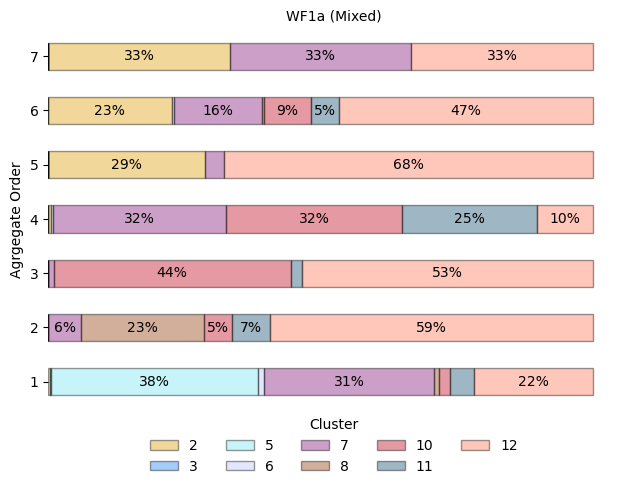

In [33]:

# load dataset
pep = "WF1a_comb"
annot=True
data = None

## Plot distribution by mer
wf1a_cluster_by_mer = wf1a_cluster.T/wf1a_cluster.T.sum(axis=0)*100
wf1a_cluster_by_mer = wf1a_cluster_by_mer.T

wf2_cluster_by_mer = wf2_cluster.T/wf2_cluster.T.sum(axis=0)*100
wf2_cluster_by_mer = wf2_cluster_by_mer.T

wf1a_cluster_only_by_mer = wf1a_cluster_only.T/wf1a_cluster_only.T.sum(axis=0)*100
wf1a_cluster_only_by_mer = wf1a_cluster_only_by_mer.T

wf2_cluster_only_by_mer = wf2_cluster_only.T/wf2_cluster_only.T.sum(axis=0)*100
wf2_cluster_only_by_mer = wf2_cluster_only_by_mer.T

if pep == "WF2_comb":
    data = wf2_cluster_by_mer
if pep == "WF1a_comb":
    data = wf1a_cluster_by_mer
if pep == "WF1a_only":
    data = wf1a_cluster_only_by_mer
if pep == "WF2_only":
    data = wf2_cluster_only_by_mer

# remove rows and columns with 0
data = data.replace(0,np.nan).dropna(axis=0,how="all")
data = data.replace(0,np.nan).dropna(axis=1,how="all")
data = data.fillna(0)
data.columns = [c.split("_")[0] for c in data.columns.tolist()]
# set the figure size
plt.figure(figsize=(14, 14))


title_d = {
    "WF1a_comb": "WF1a (Mixed)",
    "WF2_comb": "WF2 (Mixed)",
    "WF1a_only": "WF1a (Pure)",
    "WF2_only": "WF2 (Pure)",
}
colors_list_wf2 = [
    "#d7a2c5", "#c59a4c", "#76a28f", "#718a4c", "#cb82d1", "#7ea8ba", "#339df9", "#c80e4a", \
        "#dbaaff", "#59d102" ,"#ffebeb", "#4e158c", "#bfc822", "#c19cfa", "#ff7ad8", "#ffd373", \
          "#967737", "#785EF0" ,"#FFB000", "#FE6100", "#CE5891", "#009E73", "#D55E00", "#CC6677",\
          "#ffd5c2", "#f28f3b", "#2d3047", "#d5d5d5", "#93b7be", "#3bacb6","#70960c", "#e58087",\
          "#7b6ea9", "#d0c4b4", "#fce96a", "#f6921b", "#dbaaff", "#3919CE" ,"#ffebeb", "##AD5017", "#56B4E9", "#c19cfa", "#ff7ad8", "#ffd373", \
          "#dbaaff", "#59d102" ,"#ffebeb", "#EFCA79", "#bfc822", "#c19cfa", "#ff7ad8", "#ffd373",]
color_dict_wf2 = {i+1: colors_list_wf2[i] for i in range(1,21)}
colors_list_wf1a = [
        "#724363", "#1932bf", "#DC9D00", "#1f84ec", 
        "#4f8c9d", "#72e5ef", "#bbc3fe", "#800f76",
        "#8e3703", "#fbcab9", "#c00018", "#104b6d", "#fd7450", "#b38677",
        "#4f8c9d", "#72e5ef", "#104b6d", "#bbc3fe", "#800f76", "#ed8bc7",
        "#724363", "#ed2bb1", "#1932bf", "#8b6fed", "#1f84ec", 
        "#8e3703", "#fbcab9", "#c00018", "#fd7450", "#b38677"]
color_dict_wf1a = {i+1: colors_list_wf1a[i] for i in range(1,13)}


if "WF2" in pep:
    colors = {i: colors_list_wf2[i] for i in range(0, 21)}
else:
    colors = {i: colors_list_wf1a[i] for i in range(0, 13)}
print(colors)
fig, ax = plt.subplots(1,1)
data.plot(kind="barh", stacked=True, ax=ax, edgecolor = "black", alpha=0.4,
                        color=[colors[int(c)] for c in data.columns.tolist() ])

labels_len = len(data.columns.tolist())
col_legend =  labels_len/2 if labels_len%2 == 0 else labels_len/2+1
if pep in ["WF2_only", "WF1a_only"]:
    col_legend= 4
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=col_legend, title="Cluster", frameon=False)

list_values = [f"{round(x)}%"  if round(x) not in [0,4,3,2,1,5,6] else '' for x in data.values.reshape(-1)] 

if annot == True:
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if round(width) not in [0,4,3,2,1]:
            ax.text(x+width/2, 
                    y+height/2, 
                    '{:.0f}%'.format(width), 
                    horizontalalignment='center', 
                    verticalalignment='center', c="black")
ax.set_frame_on(False)
ax.set_ylabel("Agrgegate Order")
ax.set_xticks([])
plt.tight_layout()
plt.title(title_d[pep])
plt.show()

## Clusters found only as monomers

In [20]:
monomer_only_clusters = []
for c in data.columns.tolist():
    vals = data[c].values
    if vals[0] >0 and not any(vals[1:]):
        monomer_only_clusters.append((int(c), vals[0]))
monomer_only_clusters


[(11, 2.9723991507431)]

### Cluster ratio

In [ ]:
sim_type = "WF1a_WF2"
sim_number = 2
d1 = get_clusters_per_system(sim_type, sim_number, cutoff,"peptide")

all_cluster_by_type = []
for t, v in d1.items():
    t_l = []
    for cluster in v:
        transform_cluster = []
        for e in cluster:
            transform_cluster.append(get_pep_combined(e, sim_type))
        t_l.append(transform_cluster)
    all_cluster_by_type.append(t_l)
mer_peptype = {i: {"WF1a":[], "WF2": []} for i in range(1,9)}
for aggreg_list in all_cluster_by_type:
    for aggreg in aggreg_list:
        mer_order = len(aggreg)
        mer_peptype[mer_order]["WF1a"].append(aggreg.count("WF1a"))
        mer_peptype[mer_order]["WF2"].append(aggreg.count("WF2"))
for c, v in mer_peptype.items():
    for pep, l in v.items():
        mer_peptype[c][pep] = np.mean(l)
mer_peptype

reading file  WF1a_WF2_replica_interactions_true_false_100timestep_cutoff6.csv


/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{1: {'WF1a': 0.8315789473684211, 'WF2': 0.16842105263157894},
 2: {'WF1a': 1.1666666666666667, 'WF2': 0.8333333333333334},
 3: {'WF1a': 2.0, 'WF2': 1.0},
 4: {'WF1a': 1.5714285714285714, 'WF2': 2.4285714285714284},
 5: {'WF1a': 1.9565217391304348, 'WF2': 3.0434782608695654},
 6: {'WF1a': 2.2442748091603053, 'WF2': 3.7557251908396947},
 7: {'WF1a': 3.0, 'WF2': 4.0},
 8: {'WF1a': nan, 'WF2': nan}}

## Ratio of pep types per time

In [ ]:

def get_ratio_per_pep_type(sim_type, sim_number, cutoff):
    d1 = get_clusters_per_system(sim_type, sim_number, cutoff,"peptide")

    all_cluster_by_type = []
    for t, v in d1.items():
        t_l = []
        for cluster in v:
            transform_cluster = []
            for e in cluster:
                transform_cluster.append(get_pep_combined(e, sim_type))
            t_l.append(transform_cluster)
        all_cluster_by_type.append(t_l)

    mer_peptype = {i: [] for i in range(1,9)}
    for aggreg_list in all_cluster_by_type:
        for aggreg in aggreg_list:
            mer_order = len(aggreg)
            if aggreg.count("WF1a")!=0 and aggreg.count("WF2")!=0:
                mer_peptype[mer_order].append(aggreg.count("WF1a")/aggreg.count("WF2"))

    return mer_peptype
mer_pep_type_comb1 = get_ratio_per_pep_type("WF1a_WF2", 1, cutoff)
mer_pep_type_comb2 = get_ratio_per_pep_type("WF1a_WF2", 2, cutoff)
mer_pep_type_comb_all = {i: [] for i in range(1,9)}
for mer in range(1,9):
    mer_pep_type_comb_all[mer] = [*mer_pep_type_comb1[mer], *mer_pep_type_comb2[mer]]
df = pd.DataFrame.from_dict(mer_pep_type_comb_all, orient='index').T
df = df.fillna(0)

mer_pep_type_comb_all_counter = {i:{} for i in range(1,9)}
for mer in range(1,9):
    mer_pep_type_comb_all_counter[mer] = dict(Counter(mer_pep_type_comb_all[mer]))
mer_pep_type_comb_all_counter

{1: {},
 2: {1.0: 190},
 3: {2.0: 46, 0.5: 9},
 4: {3.0: 145, 1.0: 7, 0.3333333333333333: 3},
 5: {0.6666666666666666: 40, 0.25: 4, 1.5: 2},
 6: {2.0: 39, 0.5: 99, 1.0: 32},
 7: {0.75: 66},
 8: {}}

## Calculate probability of aggregatio over time


reading file  WF1a_WF2_interactions_true_false_100timestep_cutoff6.csv
reading file  WF1a_WF2_replica_interactions_true_false_100timestep_cutoff6.csv
reading file  WF1a_only_interactions_true_false_100timestep_cutoff6.csv
reading file  WF1a_only_replica_interactions_true_false_100timestep_cutoff6.csv
reading file  WF2_only_interactions_true_false_100timestep_cutoff6.csv
reading file  WF2_only_replica_interactions_true_false_100timestep_cutoff6.csv


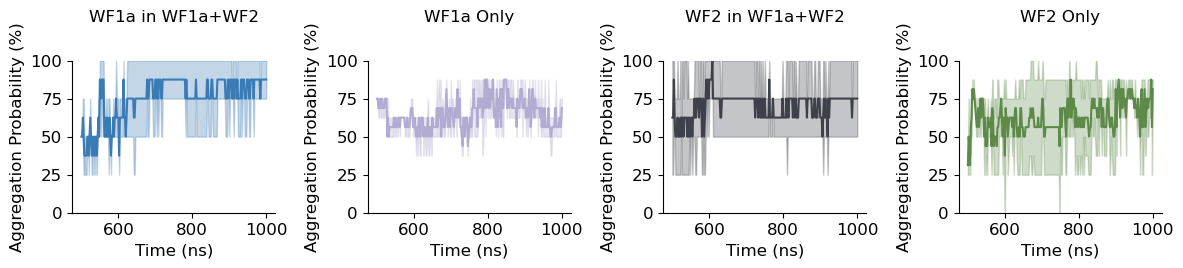

In [ ]:


def get_probability_being_in_cluster(system_type, sim_num, cutoff):
    d1 = get_clusters_per_system(system_type, sim_num, cutoff,"peptide")
    

    # get clusters by type
    all_cluster_by_type_mers = {i: [] for i in d1.keys()}

    for t, v in d1.items():
        for cluster in v:
            transform_cluster = []
            for e in cluster:
                transform_cluster.append(get_pep_combined(e, system_type))
            all_cluster_by_type_mers[t].append(transform_cluster)

    mer_peptype = {t: {"WF1a":0, "WF2": 0} for t in all_cluster_by_type_mers.keys()}
    pep_num = 4 if "only" not in system_type else 8
    for t, aggregates in all_cluster_by_type_mers.items():
        aggreg_orders_wf1a = [len(aggreg) for aggreg in aggregates if "WF1a" in aggreg]
        aggreg_orders_wf2 = [len(aggreg) for aggreg in aggregates if "WF2" in aggreg]
        mer_peptype[t]["WF1a"] = pep_num - aggreg_orders_wf1a.count(1)
        mer_peptype[t]["WF2"] = pep_num - aggreg_orders_wf2.count(1)
    x = pd.DataFrame(mer_peptype)
    x= x/pep_num *100
    x.columns = [int(c)*2+500 for c in x.columns.tolist()]
    return x

prob_comb1 = get_probability_being_in_cluster("WF1a_WF2", 1, cutoff)
prob_comb2 = get_probability_being_in_cluster("WF1a_WF2", 2, cutoff)
prob_comb = (prob_comb1+prob_comb2)/2

prob_comb1_wf1a= get_probability_being_in_cluster("WF1a_only", 1, cutoff)
prob_comb2_wf1a= get_probability_being_in_cluster("WF1a_only", 2, cutoff)
prob_comb_wf1a = (prob_comb1_wf1a+prob_comb2_wf1a)/2
prob_comb1_wf1a

prob_comb1_wf2= get_probability_being_in_cluster("WF2_only", 1, cutoff)
prob_comb2_wf2= get_probability_being_in_cluster("WF2_only", 2, cutoff)
prob_comb_wf2 = (prob_comb1_wf2+prob_comb2_wf2)/2
prob_comb1_wf2

plt.rc('axes', titlesize=12)
plt.rcParams['font.size'] = 12

colors = ["#3a7ab5","#b2abd2", "#3d424a", "#5d8a49"]
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex=True)

# axs[0].plot(prob_comb1.T["WF1a"], c=colors[0])
axs[0].plot(prob_comb.T["WF1a"], c=colors[0])
axs[0].fill_between(prob_comb1.columns.tolist(), prob_comb1.T["WF1a"], prob_comb2.T["WF1a"], color=colors[0], alpha=0.3)
axs[0].set_title("WF1a in WF1a+WF2", y=1.2)

axs[1].plot(prob_comb_wf1a.T["WF1a"], c=colors[1])
axs[1].fill_between(prob_comb1_wf1a.columns.tolist(), prob_comb1_wf1a.T["WF1a"], prob_comb2_wf1a.T["WF1a"], color=colors[1], alpha=0.3)
axs[1].set_title("WF1a Only", y=1.2)


axs[2].plot(prob_comb.T["WF2"], c=colors[2])
axs[2].fill_between(prob_comb.columns.tolist(), prob_comb1.T["WF2"], prob_comb2.T["WF2"], color=colors[2], alpha=0.3)
axs[2].set_title("WF2 in WF1a+WF2", y=1.2)

axs[3].plot(prob_comb_wf2.T["WF2"], c=colors[3])
axs[3].fill_between(prob_comb_wf2.columns.tolist(), prob_comb1_wf2.T["WF2"], prob_comb2_wf2.T["WF2"], color=colors[3], alpha=0.3)
axs[3].set_title("WF2 Only", y=1.2)

for ax in axs:
    ax.spines.top.set(visible=False)
    ax.spines.right.set(visible=False)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Aggregation Probability (%)")
    a=ax.get_xticks().tolist()
    ax.set_ylim([0, 100])

plt.tight_layout()

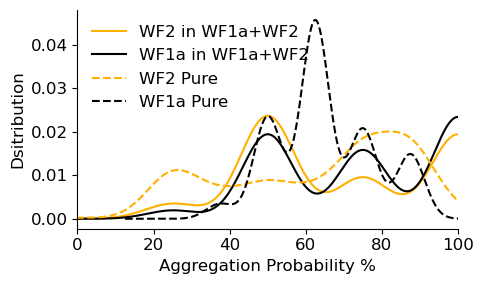

In [ ]:
plt.rc('axes', titlesize=12)
plt.rcParams['font.size'] = 12
plt.rcParams.update({'font.size': 12}) # must set in top


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))

c1 = "#FFB000"
c2 = "black"

pd.DataFrame([*prob_comb1.T["WF2"].values, *prob_comb2.T["WF2"].values], columns=["WF2 in WF1a+WF2"]).plot(kind='density', ax=ax, c=c1) 
pd.DataFrame([*prob_comb1.T["WF1a"].values, *prob_comb2.T["WF1a"].values], columns=["WF1a in WF1a+WF2"]).plot(kind='density', ax=ax, c=c2) 
pd.DataFrame([*prob_comb1_wf2.T["WF2"].values, *prob_comb2_wf2.T["WF2"].values], columns=["WF2 Pure"]).plot(kind='density', ax=ax, c=c1, linestyle='dashed') 
pd.DataFrame([*prob_comb1_wf1a.T["WF1a"].values, *prob_comb2_wf1a.T["WF1a"].values], columns=["WF1a Pure"]).plot(kind='density', ax=ax, c=c2, linestyle='dashed') 

plt.legend(frameon=False)
ax.spines.top.set(visible=False)
ax.spines.right.set(visible=False)
ax.set_ylabel("Dsitribution")
ax.set_xlabel("Aggregation Probability %")
ax.set_xlim(0,100)
plt.legend(
    loc='upper left', ncol=1, frameon=False)
plt.tight_layout()

## FInd the peptides with the highest degree centrality

In [ ]:
def get_degree_centrality_clusters_per_system(sim_type, sim_num, cutoff, analysis_type):
    df = import_raw_aggregate_data(sim_type, sim_num, cutoff)
    dict_times = {c: [] for c in range(251)}
    for index, row in df.iterrows():
        peptides = [int(index.split("_")[0][-1]), int(index.split("_")[1][-1])]
        pep1 = peptides[0]
        pep2 = peptides[1]

        
        row = row.tolist()
        for t in range(len(row)):
            if row[t] > 0:
                if analysis_type == "peptide":
                    dict_times[t].append((pep1, pep2))
                else:
                    print("no type specified")

    dict_times_clusters = {
        "WF1a": {
            i: [] for i in range(1, 13)
        },
        "WF2": {
            i: [] for i in range(1, 21)
        },
        }
    # dict_times_clusters = {c:[] for c in dict_times.keys()}
    for k, v in dict_times.items():
        G = nx.Graph()
        G.add_nodes_from(range(1, 9)) 
        G, sub_graphs = get_clusters_at_time(G, v)
        
        degree_centrality = nx.centrality.degree_centrality(G)  # save results in a variable to use again

        for p, degree_c in degree_centrality.items():
            higher_order_mers = [i for s in sub_graphs if len(s)>3 for i in s]
            if p in higher_order_mers:
                pep_type = get_pep_combined(p, sim_type)
                pep_umap = map_pep_to_umap(pep_type, p, sim_type, sim_number)
                pep_cluster = map_pep_to_cluster(k, pep_umap, pep_type)
                if 7*degree_c>0:
                    dict_times_clusters[pep_type][pep_cluster].append(int(7*degree_c))

    return dict_times_clusters

In [ ]:

system_type = "WF2_only"

x1 = get_degree_centrality_clusters_per_system(system_type, 1, cutoff, "peptide")
x2 = get_degree_centrality_clusters_per_system(system_type, 2, cutoff, "peptide")

dict_times_clusters = {
    "WF1a": {
        i: {"mean": 0, "SD": 0} for i in range(1, 13)},
    "WF2": {
        i: {"mean": 0, "SD": 0} for i in range(1, 21)},
    }
for pep, d in dict_times_clusters.items():
    for c, l in d.items():
        comb_list = [*x1[pep][c], *x2[pep][c]]
        if len(comb_list)>0:
            dict_times_clusters[pep][c]["mean"] = np.around(np.mean(comb_list),decimals=2)
            dict_times_clusters[pep][c]["SD"] = np.round(np.std(comb_list),decimals=2)

df = pd.DataFrame(dict_times_clusters)

df = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in dict_times_clusters.items()
    }, 
    axis=0).T
df = df.loc[:, (df != 0).any(axis=0)]
df

reading file  WF2_only_interactions_true_false_100timestep_cutoff6.csv
reading file  WF2_only_replica_interactions_true_false_100timestep_cutoff6.csv


WF2                                                    
       4    7     11    12    14    15    16   17    18    19
mean  1.0  1.9  1.93  2.67  2.87  1.94  1.11  1.0  1.16  1.23
SD    0.0  0.3  0.59  0.49  0.50  0.37  0.31  0.0  0.47  0.42